In [1]:
%cd '/content/drive/MyDrive/[EURON] 파이썬 머신러닝 완벽 가이드/data'

/content/drive/MyDrive/[EURON] 파이썬 머신러닝 완벽 가이드/data


In [2]:
import numpy as np
import pandas as pd

### Topic modeling guide

#### EDA

In [16]:
import numpy as np 
import pandas as pd

import sys
sys.path.append('../input/gsdmm-short-text-clustering')
#from gsdmm import MovieGroupProcess

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
import gensim, spacy
from gensim.models.ldamulticore import LdaMulticore
import re


from gensim.models import Phrases
from gensim.models.phrases import Phraser

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
data = pd.read_csv("tripadvisor_hotel_reviews.csv", encoding='utf-8')
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
data['length'] = data.Review.apply(lambda row: len(row.split()))
print('Mean length: ', data['length'].mean())

Mean length:  104.37582353228247


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


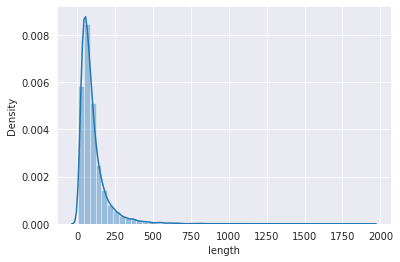

In [6]:
import seaborn as sns
sns.set_style(style="darkgrid")

sns.distplot(data['length'])

#### Preprocessing the data

In [10]:
import re

In [11]:
data['review_list'] = data.Review.values.tolist()

# remove characters
data['review_list'] = [re.sub('\s+', ' ', sent) for sent in data['review_list']]
data['review_list'] = [re.sub("\'", "", sent) for sent in data['review_list']]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [13]:
#ngram 생성 함수
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

In [17]:
tokens_reviews = list(sent_to_words(data['review_list']))

In [18]:
tokens_reviews = make_n_grams(tokens_reviews)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [19]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# 스톱워드 제거
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(['also', 'meanwhile','however', 'time', 
                                                                                                                           'hour', 'soon', 'day', 'book',
                                                                                                                           'there', 'hotel', 'room', 'leave',
                                                                                                                           'arrive',
                                                                                                                           'place', 'stay', 'staff', 'location',
                                                                                                                          'service', 'come', 'check',
                                                                                                                          'ask', 'lot', 'thing', 
                                                                                                                          'soooo', 'add', 'rarely',
                                                                                                                          'use', 'look', 'minute',
                                                                                                                          'bring', 'need', 'world',
                                                                                                                          'think', 'value', 'include']))] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
! python -m spacy download en_core_web_sm

2022-11-27 23:24:35.424776: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [21]:
reviews_lemmatized = lemmatization(tokens_reviews, allowed_postags=['NOUN', 'VERB', 'ADV'])
reviews_lemmatized = remove_stopwords(reviews_lemmatized)

#### GSDMM topic modeling

In [22]:
np.random.seed(0)

In [24]:
!pip install git+https://github.com/rwalk/gsdmm.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-kgj8c3bx
  Running command git clone -q https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-kgj8c3bx
  Created wheel for gsdmm: filename=gsdmm-0.1-py3-none-any.whl size=4601 sha256=d1e2a108696b789b20843bddca5c4e13105d51b133c2d03f5e0b50253d5948fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-8iy27ofi/wheels/34/65/a6/7eef67b88abae954fecd22587bd755c27b58a9ffe488d6b0de
Successfully built gsdmm


In [25]:
from gsdmm import MovieGroupProcess

In [26]:
mgp = MovieGroupProcess(K=6, alpha=0.01, beta=0.01, n_iters=30)

vocab = set(x for review in reviews_lemmatized for x in review)
n_terms = len(vocab)
model = mgp.fit(reviews_lemmatized, n_terms)

In stage 0: transferred 15918 clusters with 6 clusters populated
In stage 1: transferred 8796 clusters with 6 clusters populated
In stage 2: transferred 5676 clusters with 6 clusters populated
In stage 3: transferred 4305 clusters with 6 clusters populated
In stage 4: transferred 3602 clusters with 6 clusters populated
In stage 5: transferred 3156 clusters with 6 clusters populated
In stage 6: transferred 2913 clusters with 6 clusters populated
In stage 7: transferred 2609 clusters with 6 clusters populated
In stage 8: transferred 2533 clusters with 6 clusters populated
In stage 9: transferred 2428 clusters with 6 clusters populated
In stage 10: transferred 2376 clusters with 6 clusters populated
In stage 11: transferred 2370 clusters with 6 clusters populated
In stage 12: transferred 2347 clusters with 6 clusters populated
In stage 13: transferred 2351 clusters with 6 clusters populated
In stage 14: transferred 2315 clusters with 6 clusters populated
In stage 15: transferred 2339 clus

In [27]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

In [28]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 10)

Number of documents per topic : [3269 2110 1870 4714 2265 6263]

Most important clusters (by number of docs inside): [5 3 0 4 1 2]

Cluster 5 : [('resort', 8821), ('beach', 8771), ('food', 7390), ('pool', 6601), ('restaurant', 5591), ('night', 5475), ('people', 5007), ('want', 3872), ('drink', 3578), ('bar', 3444)]

Cluster 3 : [('breakfast', 3246), ('night', 2979), ('walk', 2311), ('bathroom', 1786), ('bed', 1690), ('restaurant', 1681), ('area', 1545), ('city', 1395), ('view', 1352), ('price', 1311)]

Cluster 0 : [('night', 1932), ('breakfast', 1431), ('walk', 1374), ('bed', 1269), ('restaurant', 1199), ('area', 1089), ('view', 1049), ('price', 1023), ('bathroom', 851), ('floor', 805)]

Cluster 4 : [('night', 1028), ('breakfast', 875), ('view', 835), ('restaurant', 687), ('bed', 581), ('return', 535), ('love', 532), ('experience', 513), ('recommend', 470), ('feel', 468)]

Cluster 1 : [('night', 1669), ('bed', 946), ('tell', 784), ('desk', 756), ('bathroom', 689), ('pay', 642), ('floor

In [29]:
topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6',
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [30]:
def create_topics_dataframe(data_text=data.Review,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Rating', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        result.at[i, 'Rating'] = data.Rating[i]
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(reviews_lemmatized[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [31]:
result = create_topics_dataframe(data_text=data.Review, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized)
result.head(5)

,Text,Topic,Rating,Lemma-text
0,nice hotel expensive parking got good deal sta...,type 5,4,"[parking, deal, anniversary, evening, advice, ..."
1,ok nothing special charge diamond member hilto...,Other,2,"[charge, diamond_member, decide, chain, shoot,..."
2,nice rooms not 4* experience hotel monaco seat...,type 1,3,"[experience, positive, bathroom, suite, bed, h..."
3,"unique, great stay, wonderful time hotel monac...",type 3,5,"[stroll, downtown, shopping, area, pet, sign, ..."
4,"great stay great stay, went seahawk game aweso...",type 1,5,"[game, downfall, view, building, complain, web..."


#### Visualization

In [32]:
import plotly.express as px

fig = px.pie(result, names='Topic',  title='Topics', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

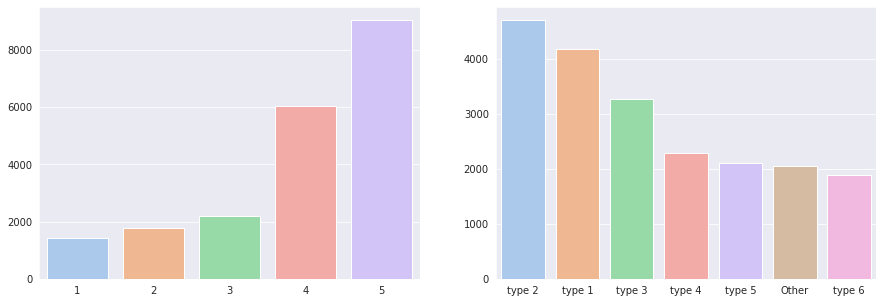

In [33]:
import matplotlib.pyplot as plt

rating_counts = result.Rating.value_counts()
types_counts = result.Topic.value_counts()
fig, ax = plt.subplots(1, 2, figsize=(15,5))
rating = sns.barplot(x = rating_counts.index, y = rating_counts.values, palette="pastel", ax=ax[0])
types = sns.barplot(x = types_counts.index, y = types_counts.values, palette="pastel", ax=ax[1])

In [34]:
fig = px.sunburst(result, path=['Topic', 'Rating'], title='Topics and ratings', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

In [35]:
result['len'] = result.Text.apply(lambda row: len(row.split()))
result.head()

,Text,Topic,Rating,Lemma-text,len
0,nice hotel expensive parking got good deal sta...,type 5,4,"[parking, deal, anniversary, evening, advice, ...",87
1,ok nothing special charge diamond member hilto...,Other,2,"[charge, diamond_member, decide, chain, shoot,...",250
2,nice rooms not 4* experience hotel monaco seat...,type 1,3,"[experience, positive, bathroom, suite, bed, h...",217
3,"unique, great stay, wonderful time hotel monac...",type 3,5,"[stroll, downtown, shopping, area, pet, sign, ...",89
4,"great stay great stay, went seahawk game aweso...",type 1,5,"[game, downfall, view, building, complain, web...",191


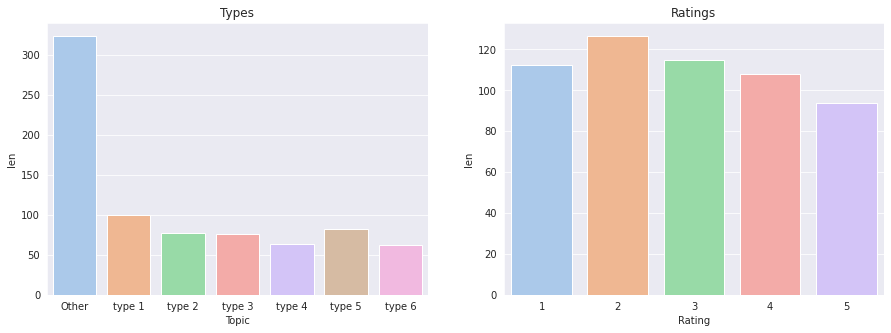

In [36]:
types_len = result.groupby(by=['Topic']).mean()
rating_len = result.groupby(by=['Rating']).mean()

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('Types')
ax[1].set_title('Ratings')
types = sns.barplot(x = types_len.index, y = types_len['len'], palette="pastel",  ax=ax[0])
rating = sns.barplot(x = rating_len.index, y = rating_len['len'], palette="pastel", ax=ax[1])

In [37]:
result.Rating = pd.to_numeric(result.Rating)

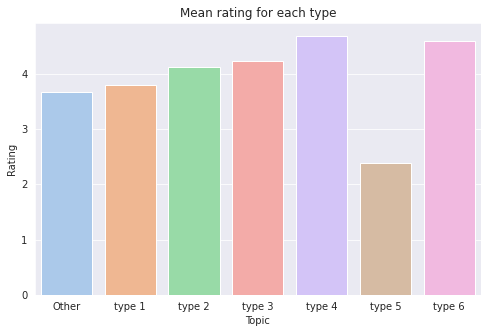

In [38]:
types_rating = result.drop('len', axis='columns').groupby(by=['Topic']).mean()

fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('Mean rating for each type')
types = sns.barplot(x = types_rating.index, y = types_rating.Rating, palette="pastel")

#### WordClouds

In [39]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))

In [40]:
result = result.drop('Lemma-text', axis=1)

In [41]:
from wordcloud import WordCloud 

In [42]:
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show()

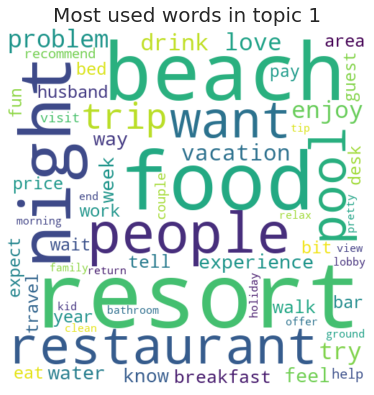

In [43]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 1'], title="Most used words in topic 1")

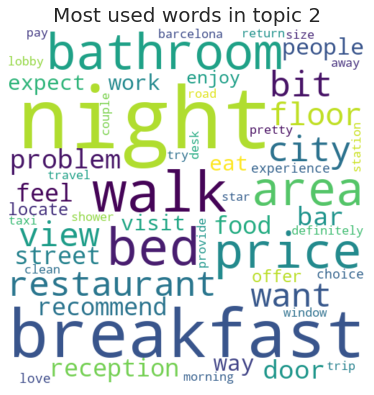

In [44]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 2'], title="Most used words in topic 2")

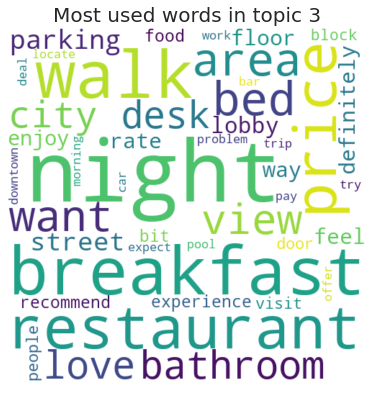

In [45]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 3'], title="Most used words in topic 3")

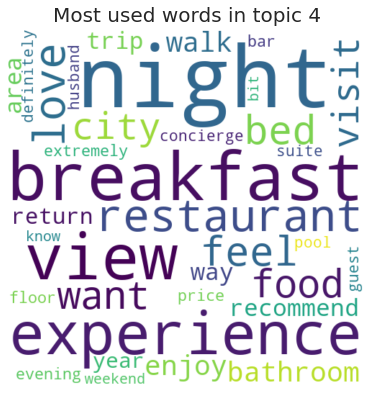

In [46]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 4'], title="Most used words in topic 4")

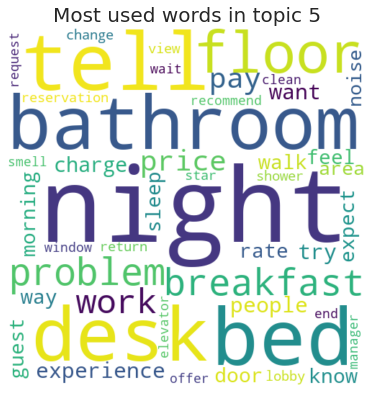

In [47]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 5'], title="Most used words in topic 5")

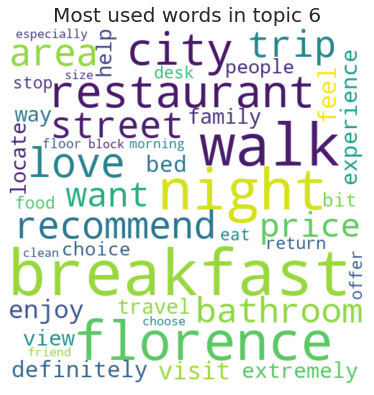

In [48]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 6'], title="Most used words in topic 6")

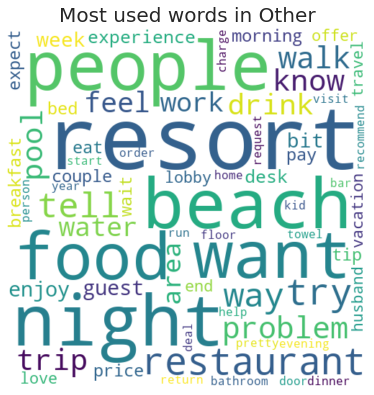

In [49]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'Other'], title="Most used words in Other")

#### LDA model

In [50]:
id2word = corpora.Dictionary(reviews_lemmatized)
texts = reviews_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [51]:
#TF-IDF 벡터화
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [52]:
from gensim.models.ldamulticore import LdaMulticore

def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = calc_coherence_values(dictionary = id2word, corpus = corpus_tfidf, texts = texts, start = 20, limit = 30, step = 2)

model created
0.4325001659163211
model created
0.4632436700066665
model created
0.5060290796206469
model created
0.523029273790638
model created
0.5032699475803716


In [53]:
import matplotlib.pyplot as plt

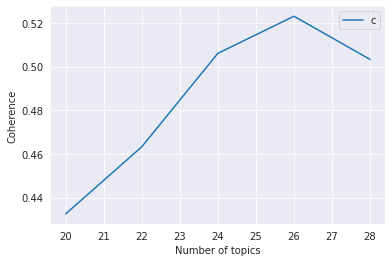

In [54]:
limit, start, step = 30, 20, 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [55]:
index = coherence_values.index(max(coherence_values))
model_list[index].show_topics()

[(23,
  '0.002*"breakfast" + 0.002*"night" + 0.002*"view" + 0.002*"bathroom" + 0.002*"city" + 0.002*"leisure" + 0.002*"walk" + 0.002*"area" + 0.002*"sleep" + 0.002*"bed"'),
 (12,
  '0.003*"century" + 0.003*"jury" + 0.002*"noice" + 0.002*"upper_floor" + 0.001*"hotle" + 0.001*"petit" + 0.001*"rubber" + 0.001*"airco" + 0.001*"smile_face" + 0.001*"swinge"'),
 (0,
  '0.008*"resort" + 0.008*"beach" + 0.007*"pool" + 0.006*"food" + 0.004*"water" + 0.004*"people" + 0.004*"bar" + 0.003*"drink" + 0.003*"restaurant" + 0.003*"trip"'),
 (16,
  '0.003*"metro" + 0.002*"duplex" + 0.002*"rennovate" + 0.002*"foward" + 0.002*"equal" + 0.002*"plunge" + 0.002*"backdrop" + 0.002*"moma" + 0.002*"malfunction" + 0.001*"off_site"'),
 (18,
  '0.012*"hong_kong" + 0.004*"mtr" + 0.004*"metro_station" + 0.002*"centrally" + 0.002*"itch" + 0.002*"mod_con" + 0.002*"omlette" + 0.002*"infinity" + 0.002*"frosted_glass" + 0.002*"cereals_bread"'),
 (21,
  '0.008*"harbour" + 0.004*"studio" + 0.002*"pont" + 0.002*"valentine" +

In [60]:
!pip install pyldavis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=2a529b5a42d96b31d80cfb135daad12c95c42dce5fd62799be00324c55dd2001
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=be778f75b4bb2c9ad22b84916feae96255ecec580a69795937c9b3d30338b78b
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built pyldavis sklearn


In [62]:
import pyLDAvis.gensim_models

lda_display = pyLDAvis.gensim_models.prepare(model_list[index], corpus_tfidf, id2word, sort_topics = False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [63]:
def format_topics_sentences(lda_model, corpus, data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [64]:
df_topic_sents_keywords = format_topics_sentences(model_list[index], corpus_tfidf, texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,22.0,0.4195,"bed, night, breakfast, walk, area, restaurant,...","[parking, deal, anniversary, evening, advice, ..."
1,1,22.0,0.7314,"bed, night, breakfast, walk, area, restaurant,...","[charge, diamond_member, decide, chain, shoot,..."
2,2,22.0,0.5140,"bed, night, breakfast, walk, area, restaurant,...","[experience, positive, bathroom, suite, bed, h..."
3,3,0.0,0.3130,"resort, beach, pool, food, water, people, bar,...","[stroll, downtown, shopping, area, pet, sign, ..."
4,4,0.0,0.4973,"resort, beach, pool, food, water, people, bar,...","[game, downfall, view, building, complain, web..."
5,5,13.0,0.5114,"resort, beach, food, pool, people, restaurant,...","[husband, weekend, attend, friend, husband, ce..."
6,6,22.0,0.7080,"bed, night, breakfast, walk, area, restaurant,...","[city, husband, spend, night, business, trip, ..."
7,7,22.0,0.2824,"bed, night, breakfast, walk, area, restaurant,...","[housekeeping, quality, chock, feel, home, exp..."
8,8,22.0,0.3581,"bed, night, breakfast, walk, area, restaurant,...","[cruise, decorate, uniquely, remodel, build, c..."
9,9,13.0,0.5567,"resort, beach, food, pool, people, restaurant,...","[reception, bed, particularly, like, reception..."


In [65]:
topic_counts = df_dominant_topic.Dominant_Topic.value_counts().sort_values(ascending=True)

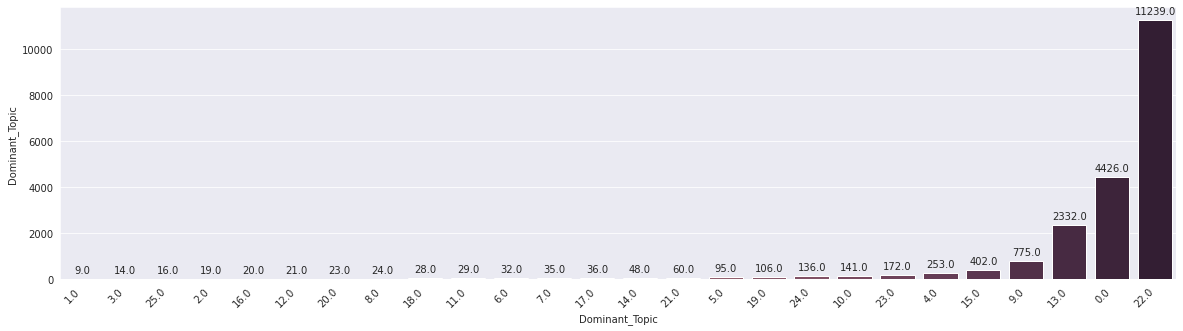

In [66]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x=topic_counts.index, y=topic_counts, data=topic_counts,  palette="ch:.25")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
ax = ax.set_xticklabels(topic_counts.index, rotation = 45, ha="right")

In [67]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head(24)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7919,"resort, beach, pool, food, water, people, bar,...","[return, week, trip, overall, enjoy, travel_ag..."
1,1.0,0.4706,"venice, requirement, stank, whack, friendly, a...","[sise, aircondtion, wery, wery, help, resepsio..."
2,2.0,0.5022,"hutong, academy, amnetie, golf, adjoin, travel...","[walk, redline, shuttle, drop, size, bed, pool..."
3,3.0,0.4997,"sydney, specially, previuo, reiview, amsterdam...","[style, breakfst, morning, walk, accadamia, di..."
4,4.0,0.6636,"bali, pool, night, restaurant, breakfast, taxi...","[relax, relax, floor, noise, night, hughe, bed..."
5,5.0,0.6027,"agua, suprise, rail, rack, breakfast, walk, ci...","[lady, girl, weekend, icaria, turn, expect, sp..."
6,6.0,0.5692,"plaza, las_rambla, dream, motivate, jadge, wal...","[loom, viaduct, courthouse, far, people, hang,..."
7,7.0,0.5187,"tapas, pig, excelent, exellent, complimentry, ...","[deal, problem, right, nitelife, canal, view, ..."
8,8.0,0.5855,"locale, hard_rock, penthouse, cleanness, fully...","[love, clemen, excellentroom, spotlessstair, b..."
9,9.0,0.7233,"resort, definitely, beach, walk, breakfast, po...","[son, rd, floor, air, wall, spotless, bathroom..."


#### LSI model

In [68]:
from gensim.models import LsiModel

In [69]:
def calc_coherence_values_Lsi(dictionary, corpus, texts, limit, start = 2, step = 2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LsiModel(corpus=corpus, id2word = dictionary, num_topics = num_topics)
        print('model created')
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


model_list, coherence_values_Lsi = calc_coherence_values_Lsi(dictionary = id2word, corpus=corpus_tfidf, texts=texts, start = 2, limit = 30, step =2)

model created
0.41399365014114664
model created
0.4051646055407586
model created
0.39027998832222427
model created
0.39801147916314017
model created
0.36831621018926475
model created
0.3628120940410673
model created
0.35375091129331265
model created
0.36988525975721087
model created
0.33636487517025493
model created
0.33703447145181864
model created
0.32836510840112704
model created
0.3246902513829915
model created
0.3213504054055163
model created
0.32680260313212267


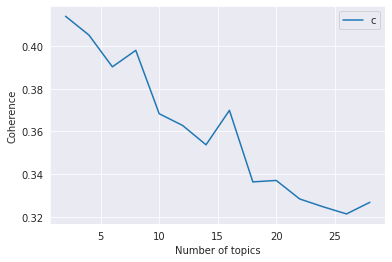

In [70]:
limit, start, step = 30, 2, 2
x = range(start, limit, step)
plt.plot(x, coherence_values_Lsi)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [71]:
index = coherence_values_Lsi.index(max(coherence_values_Lsi))
model_list[index].show_topics()

[(0,
  '0.196*"resort" + 0.173*"beach" + 0.139*"pool" + 0.136*"food" + 0.130*"restaurant" + 0.128*"night" + 0.118*"walk" + 0.114*"breakfast" + 0.114*"people" + 0.111*"area"'),
 (1,
  '-0.507*"resort" + -0.325*"beach" + -0.169*"pool" + 0.164*"city" + -0.160*"food" + 0.141*"breakfast" + -0.140*"vacation" + 0.132*"street" + 0.119*"bathroom" + 0.113*"walk"')]

### Sentiment Analysis(NLP)

In [73]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
import pandas as pd
import numpy as np
import scipy
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import Image

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/scikitplot/plotters.py:37: DeprecationWarning:

This module was deprecated in version 0.3.0 and its functions are spread throughout different modules. Please check the documentation and update your function calls as soon as possible. This module will be removed in 0.4.0



In [75]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
df.head(3)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


In [76]:
df.groupby(['Rating', 'Recommended IND'])['Recommended IND'].count()

Rating  Recommended IND
1       0                    826
        1                     16
2       0                   1471
        1                     94
3       0                   1682
        1                   1189
4       0                    168
        1                   4909
5       0                     25
        1                  13106
Name: Recommended IND, dtype: int64

In [77]:
df.loc[(df.Rating==5) & (df['Recommended IND']==0)]['Review Text'].iloc[1]

"This top is one of my retailer faves! it is so comfortable and love the quality and design. i receive many compliments on this top. i usually wear an xs or s in retailer tops and the xs was a little tight in the arms. the dressing room attendant suggested ordering a petite small so i wouldn't lose the shape. so glad i did. it fits perfect! i even ordered when it was on sale!! the gray color is perfect! its not too thick or thin."

#### Text Features

In [78]:
text_df = df[['Title', 'Review Text', 'Recommended IND']]
text_df.head()

,Title,Review Text,Recommended IND
0,NaN,Absolutely wonderful - silky and sexy and comf...,1
1,NaN,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws,I had such high hopes for this dress and reall...,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1
4,Flattering shirt,This shirt is very flattering to all due to th...,1


In [79]:
# 텍스트 피처 병합하기
text_df['Review'] = text_df['Title'] + ' ' + text_df['Review Text']
text_df = text_df.drop(labels=['Title','Review Text'] , axis=1)
text_df.head()

,Recommended IND,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


In [80]:
text_df.Review.isna().sum()

3811

In [81]:
text_df = text_df[~text_df.Review.isna()]
text_df = text_df.rename(columns={"Recommended IND": "Recommended"})
print("My data's shape is:", text_df.shape)
text_df.head()

My data's shape is: (19675, 2)


,Recommended,Review
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...
5,0,Not for the very petite I love tracy reese dre...
6,1,Cagrcoal shimmer fun I aded this in my basket ...


In [82]:
text_df['Recommended'].unique()

array([0, 1])

In [83]:
text_df['Recommended'].value_counts(normalize=True)

1    0.818297
0    0.181703
Name: Recommended, dtype: float64

In [84]:
text_df['Review_length'] = text_df['Review'].apply(len)
print(text_df.shape)
text_df.head()

(19675, 3)


,Recommended,Review,Review_length
2,0,Some major design flaws I had such high hopes ...,524
3,1,"My favorite buy! I love, love, love this jumps...",141
4,1,Flattering shirt This shirt is very flattering...,209
5,0,Not for the very petite I love tracy reese dre...,512
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517


In [85]:
text_df['Review_length'].describe()

count    19675.000000
mean       338.450267
std        144.740126
min         23.000000
25%        217.000000
50%        336.000000
75%        496.000000
max        557.000000
Name: Review_length, dtype: float64

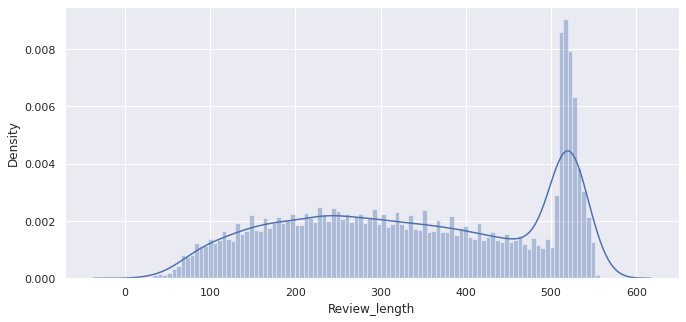

In [86]:
sns.set(rc={'figure.figsize':(11,5)})
sns.distplot(text_df['Review_length'] ,hist=True, bins=100)

In [87]:
df_zero = text_df[text_df['Recommended']==0]
df_one = text_df[text_df['Recommended']==1]

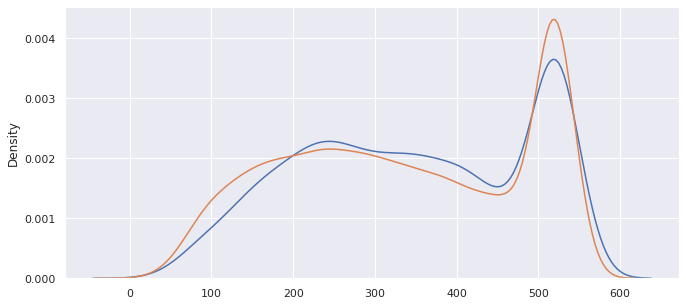

In [88]:
sns.distplot(df_zero[['Review_length']] ,hist=False)
sns.distplot(df_one[['Review_length']], hist=False)

In [89]:
def count_exclamation_mark(string_text):
    count = 0
    for char in string_text:
        if char == '!':
            count += 1
    return count

In [90]:
text_df['count_exc'] = text_df['Review'].apply(count_exclamation_mark)
text_df.head(5)

,Recommended,Review,Review_length,count_exc
2,0,Some major design flaws I had such high hopes ...,524,1
3,1,"My favorite buy! I love, love, love this jumps...",141,3
4,1,Flattering shirt This shirt is very flattering...,209,3
5,0,Not for the very petite I love tracy reese dre...,512,0
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0


In [91]:
text_df['count_exc'].describe(np.arange(0.2, 1.0, 0.2))

count    19675.000000
mean         0.883151
std          1.412098
min          0.000000
20%          0.000000
40%          0.000000
50%          0.000000
60%          1.000000
80%          2.000000
max         41.000000
Name: count_exc, dtype: float64

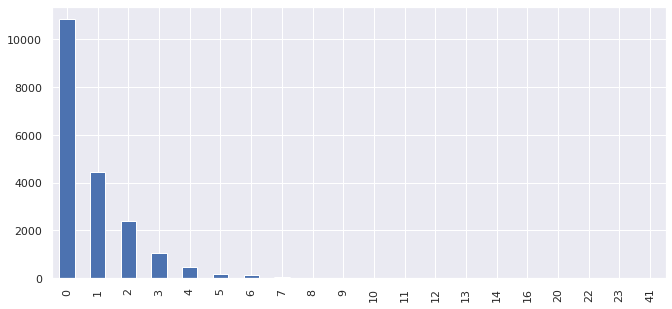

In [92]:
text_df['count_exc'].value_counts().sort_index().plot(kind='bar')

In [93]:
text_df[text_df['count_exc']== 41].index

Int64Index([3301], dtype='int64')

In [94]:
text_df['Review'][3301]

'Beautiful and unique. Love this top, just received it today.\r\nit is a very artistic interpretation for a casual top.\r\nthe blue is gorgeous!\r\nthe unique style of the peplm and the details on the front set this apart!\r\nruns a little shorter, but i feel the length enhances it;s beauty, and is appropriate for the overall design.\r\nlove !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\r\nordered my usual size and it fits perfectly.'

In [95]:
text_df['Polarity'] = text_df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
text_df.head(5)

,Recommended,Review,Review_length,count_exc,Polarity
2,0,Some major design flaws I had such high hopes ...,524,1,0.073209
3,1,"My favorite buy! I love, love, love this jumps...",141,3,0.560714
4,1,Flattering shirt This shirt is very flattering...,209,3,0.512891
5,0,Not for the very petite I love tracy reese dre...,512,0,0.181111
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0,0.157500


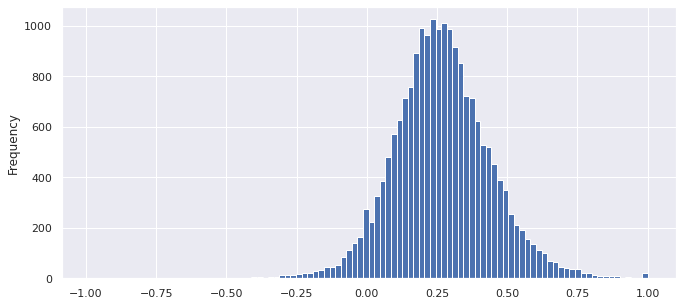

In [96]:
text_df['Polarity'].plot(kind='hist', bins=100)

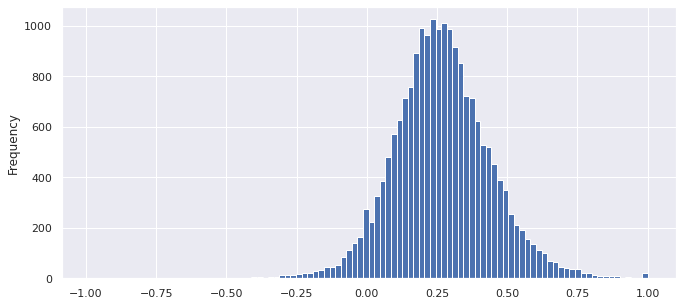

In [97]:
text_df['Polarity'].plot(kind='hist', bins=100)

In [98]:
text_prep = text_df.copy()

#### Preprocessing

In [99]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [100]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [101]:
text_prep['Review'] = text_prep['Review'].apply(punctuation_removal)
text_prep['Review'].head()

2    Some major design flaws I had such high hopes ...
3    My favorite buy I love love love this jumpsuit...
4    Flattering shirt This shirt is very flattering...
5    Not for the very petite I love tracy reese dre...
6    Cagrcoal shimmer fun I aded this in my basket ...
Name: Review, dtype: object

In [102]:
Image(url= "http://josecarilloforum.com/imgs/longnounphrase_schematic-1B.png", width=600, height=10)

In [103]:
def adj_collector(review_string):
    new_string=[]
    review_string = word_tokenize(review_string)
    tup_word = nltk.pos_tag(review_string)
    for tup in tup_word:
        if 'VB' in tup[1] or tup[1]=='JJ':  #Verbs and Adjectives
            new_string.append(tup[0])  
    return ' '.join(new_string)

In [107]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [108]:
text_prep['Review'] = text_prep['Review'].apply(adj_collector)
text_prep['Review'].head(7)

2    major had such high wanted work i ordered smal...
3         favorite love love fabulous wear i get great
4    Flattering is flattering due adjustable is per...
5    petite love reese is petite am tall wear was i...
6    aded last see look i went am pale is gorgeous ...
7    goes ordered had try used top pair went is nic...
8    Flattering love get runs little ordered flatte...
Name: Review, dtype: object

In [112]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [113]:
print(stopwords.words('english')[::12])

['i', "you'd", 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', "don't", 'aren', 'haven', "shan't"]


In [114]:
stop = stopwords.words('english')
stop.append("i'm")

In [115]:
stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 
print(stop_words[::12])

['i', 'youd', 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', 'dont', 'aren', 'haven', 'shant']


In [116]:
clothes_list =['dress', 'top','sweater','shirt',
               'skirt','material', 'white', 'black',
              'jeans', 'fabric', 'color','order', 'wear']

In [117]:
def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words and word.lower() not in clothes_list ]

In [118]:
text_prep['Review'] = text_prep['Review'].apply(stopwords_removal)
text_prep['Review'].head()

2    [major, high, wanted, work, ordered, small, us...
3         [favorite, love, love, fabulous, get, great]
4    [flattering, flattering, due, adjustable, perf...
5    [petite, love, reese, petite, tall, long, full...
6    [aded, last, see, look, went, pale, gorgeous, ...
Name: Review, dtype: object

In [119]:
print(text_prep['Review'][3301])

['unique', 'received', 'artistic', 'casual', 'gorgeous', 'unique', 'runs', 'little', 'feel', 'enhances', 'appropriate', 'overall', 'ordered', 'usual', 'fits']


In [120]:
print(text_prep['Review'][267])

['nice', 'short', 'tall', 'iamp39d', 'say', 'fits', 'true', 'short', 'iamp39m', 'tall', 'wish', 'came']


In [121]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

In [122]:
text_prep['Review'] = text_prep['Review'].apply(drop_numbers)
text_prep['Review'].head()

2    major high wanted work ordered small usual fou...
3                favorite love love fabulous get great
4    flattering flattering due adjustable perfect p...
5    petite love reese petite tall long full overwh...
6    aded last see look went pale gorgeous turns ma...
Name: Review, dtype: object

In [123]:
print(text_prep['Review'][267]) 

nice short tall say fits true short tall wish came


In [124]:
print(text_prep['Review'][2293])

flattering purchased return expected fit said lbs got get disappointed soft purchase regular fit looked terrible say tall thin yes short petite


In [125]:
# stemming
porter = PorterStemmer()

In [126]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: x.split())
text_prep['Review'].head()

2    [major, high, wanted, work, ordered, small, us...
3         [favorite, love, love, fabulous, get, great]
4    [flattering, flattering, due, adjustable, perf...
5    [petite, love, reese, petite, tall, long, full...
6    [aded, last, see, look, went, pale, gorgeous, ...
Name: Review, dtype: object

In [127]:
def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = porter.stem(word)
        text_list_new.append(word) 
    return text_list_new

In [128]:
text_prep['Review'] = text_prep['Review'].apply(stem_update)
text_prep['Review'].head()

2    [major, high, want, work, order, small, usual,...
3             [favorit, love, love, fabul, get, great]
4    [flatter, flatter, due, adjust, perfect, pair,...
5    [petit, love, rees, petit, tall, long, full, o...
6    [ade, last, see, look, went, pale, gorgeou, tu...
Name: Review, dtype: object

In [129]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: ' '.join(x))
text_prep['Review'].head()

2    major high want work order small usual found s...
3                    favorit love love fabul get great
4     flatter flatter due adjust perfect pair cardigan
5    petit love rees petit tall long full overwhelm...
6    ade last see look went pale gorgeou turn mathc...
Name: Review, dtype: object

In [130]:
print(text_prep['Review'][2293])

flatter purchas return expect fit said lb got get disappoint soft purchas regular fit look terribl say tall thin ye short petit


#### WordCloud

In [131]:
pos_df = text_prep[text_prep.Recommended== 1]
neg_df = text_prep[text_prep.Recommended== 0]
pos_df.head(3)

,Recommended,Review,Review_length,count_exc,Polarity
3,1,favorit love love fabul get great,141,3,0.560714
4,1,flatter flatter due adjust perfect pair cardigan,209,3,0.512891
6,1,ade last see look went pale gorgeou turn mathc...,517,0,0.157500


In [132]:
pos_words =[]
neg_words = []

for review in pos_df.Review:
    pos_words.append(review) 
pos_words = ' '.join(pos_words)
pos_words[:40]

for review in neg_df.Review:
    neg_words.append(review)
neg_words = ' '.join(neg_words)
neg_words[:400]

'major high want work order small usual found small small zip reorder petit ok overal comfort fit bottom tight sever cheap imo major net c petit love rees petit tall long full overwhelm small shorten narrow take love work return look cheap run small run order fit tight cheap pull caus rip disappoint go say go look style side purchas knew larg next imposs second look cheap awkward tight look describ'

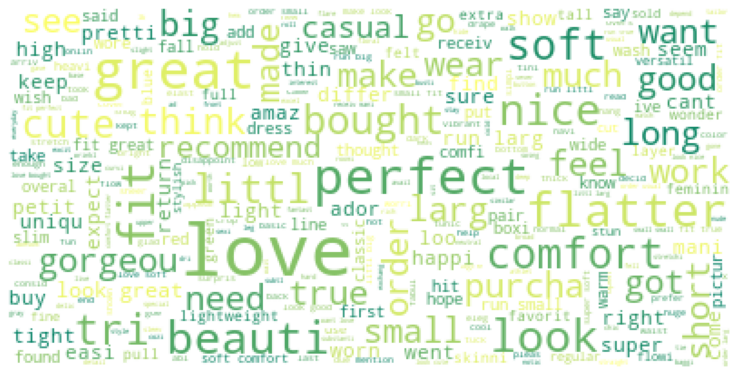

In [133]:
wordcloud = WordCloud().generate(pos_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer').generate(pos_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

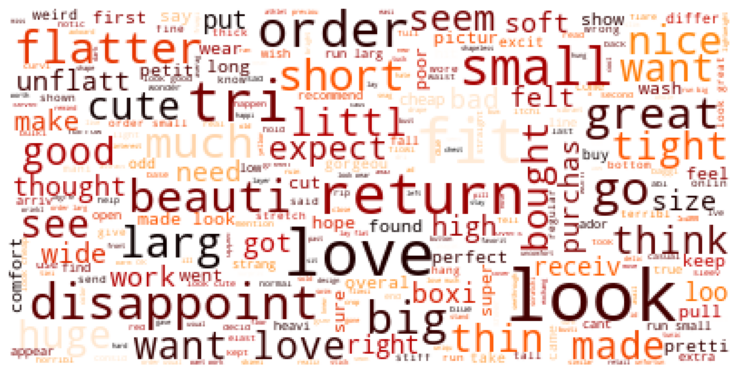

In [134]:
wordcloud = WordCloud().generate(neg_words)

wordcloud = WordCloud(background_color="white",max_words=len(neg_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat').generate(neg_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Vectorizing - BoW

In [135]:
text_prep['Review'].head()

2    major high want work order small usual found s...
3                    favorit love love fabul get great
4     flatter flatter due adjust perfect pair cardigan
5    petit love rees petit tall long full overwhelm...
6    ade last see look went pale gorgeou turn mathc...
Name: Review, dtype: object

In [136]:
def text_vectorizing_process(sentence_string):
    return [word for word in sentence_string.split()]

In [143]:
bow_transformer = CountVectorizer()

In [144]:
bow_transformer.fit(text_prep['Review'])

CountVectorizer()

In [145]:
print(text_prep['Review'].iloc[3])

petit love rees petit tall long full overwhelm small shorten narrow take love work return


In [146]:
example = bow_transformer.transform([text_prep['Review'].iloc[3]])
print(example)

  (0, 2416)	1
  (0, 3438)	1
  (0, 3507)	2
  (0, 3881)	1
  (0, 4302)	1
  (0, 4438)	2
  (0, 4875)	1
  (0, 5004)	1
  (0, 5383)	1
  (0, 5601)	1
  (0, 6196)	1
  (0, 6201)	1
  (0, 7159)	1


In [147]:
Reviews = bow_transformer.transform(text_prep['Review'])
Reviews

<19675x7277 sparse matrix of type '<class 'numpy.int64'>'
	with 237960 stored elements in Compressed Sparse Row format>

In [148]:
print('Shape of Sparse Matrix', Reviews.shape)
print('Amount of Non-Zero occurences:', Reviews.nnz)

Shape of Sparse Matrix (19675, 7277)
Amount of Non-Zero occurences: 237960


#### TF-IDF

In [149]:
tfidf_transformer = TfidfTransformer().fit(Reviews)

tfidf_example = tfidf_transformer.transform(example)
print (tfidf_example)

  (0, 7159)	0.18474832182622425
  (0, 6201)	0.2570248132639302
  (0, 6196)	0.2365171129379326
  (0, 5601)	0.1442941606293562
  (0, 5383)	0.355252429679757
  (0, 5004)	0.1888712992199643
  (0, 4875)	0.393148931086517
  (0, 4438)	0.4065409531496632
  (0, 4302)	0.3214748504588952
  (0, 3881)	0.3072123012448639
  (0, 3507)	0.21175884431125436
  (0, 3438)	0.20250236542769373
  (0, 2416)	0.2403172376641177


In [150]:
[i for i in bow_transformer.vocabulary_.items() if i[1]==3507]

[('love', 3507)]

In [151]:
[i for i in bow_transformer.vocabulary_.items()][6:60:10]

[('usual', 6813),
 ('tight', 6383),
 ('flatter', 2243),
 ('overwhelm', 4302),
 ('pale', 4323),
 ('said', 5133)]

In [152]:
messages_tfidf = tfidf_transformer.transform(Reviews)
messages_tfidf.shape

(19675, 7277)

In [153]:
print(messages_tfidf[:1]) 

  (0, 7273)	0.21472646647428087
  (0, 7159)	0.12712196996857394
  (0, 6930)	0.12017260570324308
  (0, 6813)	0.1513403250714934
  (0, 6383)	0.14060642619885752
  (0, 5601)	0.29785858576976637
  (0, 5290)	0.18845614450376966
  (0, 4943)	0.2444427546112772
  (0, 4438)	0.13986672876492434
  (0, 4260)	0.15858178150697497
  (0, 4210)	0.1001757163619286
  (0, 4138)	0.20901503445074096
  (0, 3944)	0.30397328049150685
  (0, 3584)	0.5250571838807988
  (0, 2934)	0.3111586573431781
  (0, 2769)	0.14606384138147635
  (0, 2364)	0.15056928107008546
  (0, 2197)	0.08515558755200825
  (0, 1153)	0.10625437706817653
  (0, 984)	0.19198542692781725
  (0, 698)	0.18408106529286453


In [154]:
messages_tfidf = messages_tfidf.toarray()
messages_tfidf = pd.DataFrame(messages_tfidf)
print(messages_tfidf.shape)
messages_tfidf.head()

(19675, 7277)


,0,1,2,3,4,5,6,7,8,9,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.214726,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [155]:
df_all = pd.merge(text_prep.drop(columns='Review'),messages_tfidf, 
                  left_index=True, right_index=True )
df_all.head()

,Recommended,Review_length,count_exc,Polarity,0,1,2,3,4,5,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
2,0,524,1,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,141,3,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,209,3,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,512,0,0.181111,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,517,0,0.157500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### data split

In [156]:
X = df_all.drop('Recommended', axis=1)
y = df_all.Recommended

X.head()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
2,524,1,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,141,3,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,209,3,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,512,0,0.181111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,517,0,0.157500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
X.shape

(16481, 7280)

In [158]:
X.describe()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
count,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.0,16481.000000,16481.000000,16481.000000,...,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000
mean,338.411261,0.876221,0.265987,0.000024,0.000030,0.000024,0.0,0.000049,0.000021,0.000020,...,0.000023,0.000025,0.000076,0.000048,0.000054,0.000021,0.002118,0.000315,0.000030,0.000125
std,144.790275,1.414203,0.172803,0.003139,0.003794,0.003098,0.0,0.004483,0.002695,0.002549,...,0.002950,0.003207,0.004952,0.004398,0.004935,0.002727,0.027395,0.010892,0.003799,0.007291
min,23.000000,0.000000,-0.987500,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,217.000000,0.000000,0.158333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,335.000000,0.000000,0.260863,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,497.000000,1.000000,0.370312,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,557.000000,41.000000,1.000000,0.402938,0.487124,0.397730,0.0,0.447529,0.345954,0.327234,...,0.378710,0.411733,0.382191,0.400114,0.496872,0.350060,0.629020,0.484828,0.487690,0.526867


In [159]:
X_train, X_test, y_train, y_test = split(X,y, test_size=0.3, stratify=y, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11536, 7280), (4945, 7280), (11536,), (4945,))

In [160]:
y_train.value_counts(normalize=True)

1    0.818741
0    0.181259
Name: Recommended, dtype: float64

In [161]:
y_test.value_counts(normalize=True)

1    0.818605
0    0.181395
Name: Recommended, dtype: float64

In [162]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [163]:
pd.DataFrame(X_train_scaled,columns= X_train.columns).describe()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
count,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.0,11536.000000,11536.000000,11536.000000,...,11536.000000,11536.0,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.0,11536.000000
mean,0.587341,0.021667,0.631576,0.000087,0.000087,0.000087,0.0,0.000087,0.000087,0.000087,...,0.000087,0.0,0.000285,0.000087,0.000155,0.000087,0.003269,0.000680,0.0,0.000340
std,0.272417,0.035310,0.087348,0.009310,0.009310,0.009310,0.0,0.009310,0.009310,0.009310,...,0.009310,0.0,0.015486,0.009310,0.011872,0.009310,0.043065,0.023211,0.0,0.016539
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.357678,0.000000,0.577737,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.578652,0.000000,0.628931,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.885768,0.024390,0.683922,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


#### PCA

In [164]:
pca_transformer = PCA(n_components=2).fit(X_train_scaled)
X_train_scaled_pca = pca_transformer.transform(X_train_scaled)
X_test_scaled_pca = pca_transformer.transform(X_test_scaled)
X_train_scaled_pca[:1]

array([[-0.13600041, -0.04939817]])

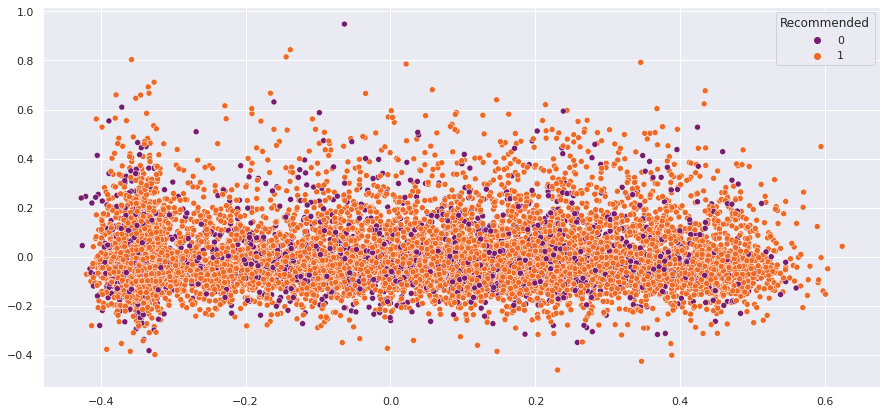

In [165]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=X_train_scaled_pca[:, 0], 
                y=X_train_scaled_pca[:, 1], 
                hue=y_train, 
                sizes=100,
                palette="inferno") 

In [166]:
X_train_scaled = scipy.sparse.csr_matrix(X_train_scaled)
X_test_scaled = scipy.sparse.csr_matrix(X_test_scaled)

X_train = scipy.sparse.csr_matrix(X_train.values)
X_test = scipy.sparse.csr_matrix(X_test.values)
X_test

<4945x7280 sparse matrix of type '<class 'numpy.float64'>'
	with 71934 stored elements in Compressed Sparse Row format>

#### model

In [167]:
def report(y_true, y_pred, labels):
    cm = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred), 
                                        index=labels, columns=labels)
    rep = classification_report(y_true=y_true, y_pred=y_pred)
    return (f'Confusion Matrix:\n{cm}\n\nClassification Report:\n{rep}')

In [168]:
#SVM
svc_model = SVC(C=1.0, 
             kernel='linear',
             class_weight='balanced', 
             probability=True,
             random_state=111)
svc_model.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', kernel='linear', probability=True,
    random_state=111)

In [169]:
test_predictions = svc_model.predict(X_test_scaled)
print(report(y_test, test_predictions, svc_model.classes_ ))

Confusion Matrix:
     0     1
0  517   380
1  995  3053

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.58      0.43       897
           1       0.89      0.75      0.82      4048

    accuracy                           0.72      4945
   macro avg       0.62      0.67      0.62      4945
weighted avg       0.79      0.72      0.75      4945



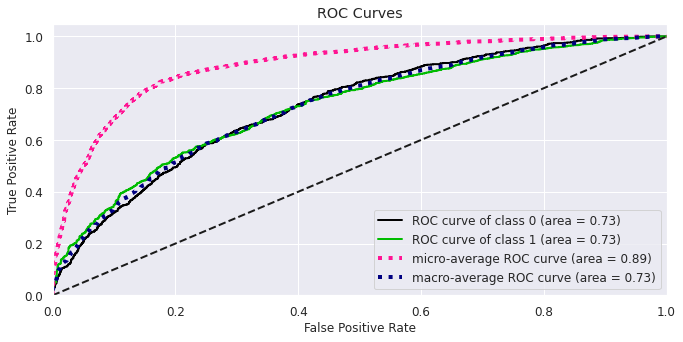

In [170]:
skplt.metrics.plot_roc(y_test, svc_model.predict_proba(X_test_scaled)) 

In [171]:
# Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', 
                              random_state=111, 
                              solver='lbfgs',
                              C=1.0)

gs_lr_model = GridSearchCV(lr_model, 
                           param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, 
                           cv=5, 
                           scoring='roc_auc')

gs_lr_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=111),
             param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, scoring='roc_auc')

In [172]:
gs_lr_model.best_params_

{'C': 0.1}

In [173]:
test_predictions = gs_lr_model.predict(X_test_scaled)
print(report(y_test, test_predictions, gs_lr_model.classes_ ))

Confusion Matrix:
      0     1
0   617   280
1  1100  2948

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.69      0.47       897
           1       0.91      0.73      0.81      4048

    accuracy                           0.72      4945
   macro avg       0.64      0.71      0.64      4945
weighted avg       0.81      0.72      0.75      4945



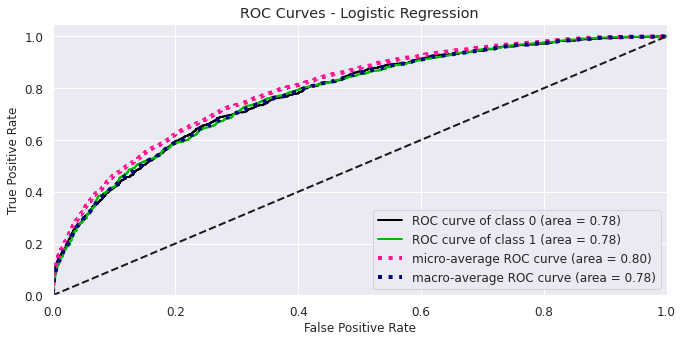

In [174]:
skplt.metrics.plot_roc(y_test, gs_lr_model.predict_proba(X_test_scaled),
                      title='ROC Curves - Logistic Regression')

In [175]:
# AdaBoost
dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=555)

ada_model = AdaBoostClassifier(base_estimator=dt, learning_rate=0.001, n_estimators=1000, random_state=222)
ada_model.fit(X_train ,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=5,
                                                         random_state=555),
                   learning_rate=0.001, n_estimators=1000, random_state=222)

In [176]:
test_predictions = ada_model.predict(X_test)
print(report(y_test, test_predictions, ada_model.classes_ ))

Confusion Matrix:
     0     1
0  549   348
1  916  3132

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.61      0.46       897
           1       0.90      0.77      0.83      4048

    accuracy                           0.74      4945
   macro avg       0.64      0.69      0.65      4945
weighted avg       0.80      0.74      0.77      4945



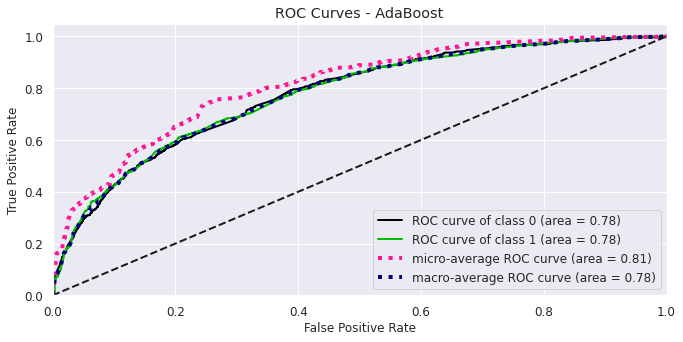

In [177]:
skplt.metrics.plot_roc(y_test, ada_model.predict_proba(X_test), 
                       title='ROC Curves - AdaBoost') 

In [178]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=5, 
                                  class_weight='balanced', random_state=3)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=1000,
                       random_state=3)

In [179]:
test_predictions = rf_model.predict(X_test)
print(report(y_test, test_predictions, rf_model.classes_ ))

Confusion Matrix:
     0     1
0  535   362
1  828  3220

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.60      0.47       897
           1       0.90      0.80      0.84      4048

    accuracy                           0.76      4945
   macro avg       0.65      0.70      0.66      4945
weighted avg       0.81      0.76      0.78      4945



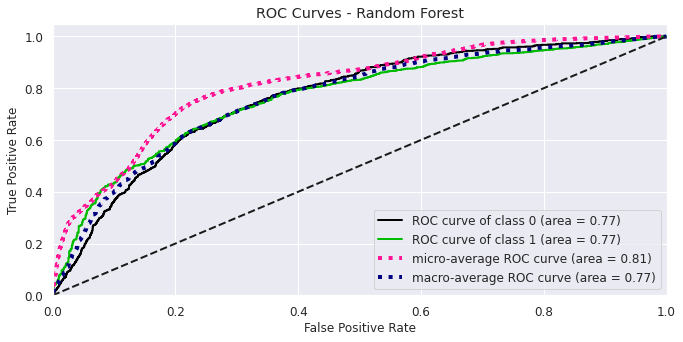

In [180]:
skplt.metrics.plot_roc(y_test, rf_model.predict_proba(X_test), 
                       title='ROC Curves - Random Forest') 

In [181]:
my_list = list(zip(rf_model.feature_importances_ ,X.columns))
my_list.sort(key=lambda tup: tup[0],reverse=True)
my_list[:7]

[(0.06291527997677081, 'Polarity'),
 (0.055157105857121864, 'count_exc'),
 (0.021406639244383446, 'Review_length'),
 (0.011894601207282649, 3465),
 (0.009851650847294266, 2416),
 (0.009284936953421651, 2546),
 (0.009115202968963206, 3522)]

In [182]:
bow_list = [i for i in bow_transformer.vocabulary_.items()]

for i in my_list:
    for j in bow_list:
        if i[1] == j[1] and i[0]> 0.005:
            print(f'Importance: {i[0]:.4f}   Word num: {i[1]}   Word:  { j[0]}')

Importance: 0.0119   Word num: 3465   Word:  look
Importance: 0.0099   Word num: 2416   Word:  full
Importance: 0.0093   Word num: 2546   Word:  good
Importance: 0.0091   Word num: 3522   Word:  low
Importance: 0.0081   Word num: 2042   Word:  extra
Importance: 0.0068   Word num: 2364   Word:  found
Importance: 0.0059   Word num: 3212   Word:  knew
Importance: 0.0055   Word num: 4832   Word:  receiv
Importance: 0.0055   Word num: 1605   Word:  differ
Importance: 0.0054   Word num: 763   Word:  bright
Importance: 0.0051   Word num: 5098   Word:  run
Importance: 0.0051   Word num: 873   Word:  buy
Importance: 0.0051   Word num: 2197   Word:  fit
Importance: 0.0050   Word num: 3438   Word:  long


In [183]:
probs = rf_model.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, probs[:,1])

Text(0, 0.5, 'TPR')

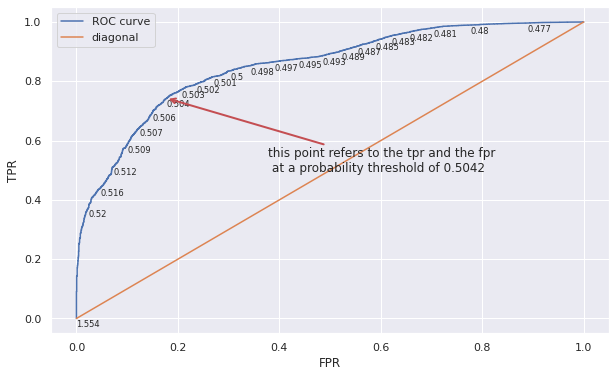

In [184]:
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::100], tpr[::100], thresholds[::100]):
    plt.annotate(np.round(txt,3), (x, y-0.03), fontsize='x-small')
rnd_idx = 700
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'\
             .format(np.round(thresholds[rnd_idx], 4)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->',color='r'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [185]:
probs = rf_model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:,1])

Text(0, 0.5, 'TPR')

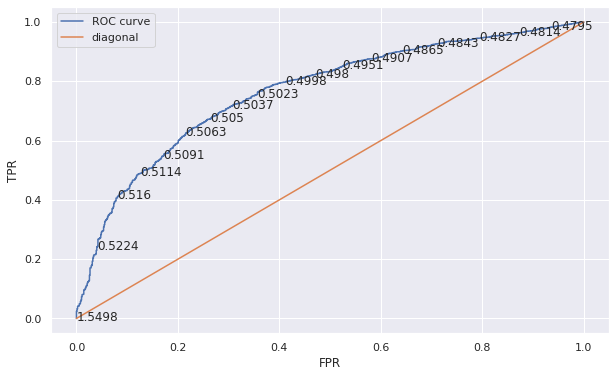

In [186]:
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::70], tpr[::70], thresholds[::70]):
    plt.annotate(np.round(txt,4), (x, y-0.01))

plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")